In [1]:
import pandas as pd

In [2]:
df=pd.read_excel("/content/drive/MyDrive/Main Project dataset.xlsx")
df.head()

,IMAGE,DESCRIPTION
0,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
1,1002674143_1b742ab4b8.jpg,A little girl is sitting in front of a large p...
2,1002674143_1b742ab4b8.jpg,A small girl in the grass plays with fingerpai...
3,1002674143_1b742ab4b8.jpg,There is a girl with pigtails sitting in front...
4,1002674143_1b742ab4b8.jpg,Young girl with pigtails painting outside in t...


In [3]:
df.shape

(32225, 2)

In [4]:
import os

def count_images_in_directory(directory_path):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')  # Add any other relevant extensions
    image_count = sum(1 for filename in os.listdir(directory_path) if filename.lower().endswith(image_extensions))
    return image_count

# Example usage
directory_path = '/content/drive/MyDrive/Images - Copy'
print(f"Number of images in the dataset: {count_images_in_directory(directory_path)}")


Number of images in the dataset: 6458


In [5]:
import pandas as pd
import os
from PIL import Image

# Load Excel file
excel_path = '/content/drive/MyDrive/Main Project dataset.xlsx'
df = pd.read_excel(excel_path)

# List all images in the specified directory
image_directory = '/content/drive/MyDrive/Images - Copy'
image_files = os.listdir(image_directory)

# Extract image filenames from the DataFrame
excel_image_files = df['IMAGE'].apply(lambda x: os.path.basename(x))

In [6]:
# Identify missing images
missing_images = df[~excel_image_files.isin(image_files)]

# Print the missing images and their descriptions
print("Missing images and their descriptions:")
print(missing_images)

# Remove rows with missing images
df_cleaned = df[excel_image_files.isin(image_files)]

Missing images and their descriptions:
Empty DataFrame
Columns: [IMAGE, DESCRIPTION ]
Index: []


In [7]:
# Save the updated DataFrame back to the Excel file
df_cleaned.to_excel(excel_path, index=False)
print(f"Updated Excel file saved to {excel_path}")

Updated Excel file saved to /content/drive/MyDrive/Main Project dataset.xlsx


In [8]:
df.shape

(32225, 2)

In [9]:
# Check the data type of the 'DESCRIPTION' column
print(df['DESCRIPTION '].dtype)

# If the descriptions are already lists, no need to split
# Otherwise, split by delimiter '|'
if isinstance(df['DESCRIPTION '].iloc[0], str):
    df['DESCRIPTION '] = df['DESCRIPTION '].apply(lambda x: x.split('|'))

# Display the first few rows to verify the changes
print(df.head())

object
                       IMAGE  \
0  1002674143_1b742ab4b8.jpg   
1  1002674143_1b742ab4b8.jpg   
2  1002674143_1b742ab4b8.jpg   
3  1002674143_1b742ab4b8.jpg   
4  1002674143_1b742ab4b8.jpg   

                                        DESCRIPTION   
0  [A little girl covered in paint sits in front ...  
1  [A little girl is sitting in front of a large ...  
2  [A small girl in the grass plays with fingerpa...  
3  [There is a girl with pigtails sitting in fron...  
4  [Young girl with pigtails painting outside in ...  


In [10]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 19.2 MB/s eta 0:00:00


In [11]:
import spacy
import numpy as np
import os
import pandas as pd
from torchvision import models, transforms
from PIL import Image
import torch
import faiss

In [12]:
# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

In [13]:
# Define a function to extract features from text using SpaCy
def extract_text_features(description, max_length=50):
    doc = nlp(description)
    features = np.array([token.vector for token in doc])
    # Pad or truncate to fixed length
    if features.shape[0] > max_length:
        features = features[:max_length]
    elif features.shape[0] < max_length:
        pad_width = max_length - features.shape[0]
        features = np.pad(features, ((0, pad_width), (0, 0)), mode='constant')
    return features.flatten()

In [14]:
# Define a function to extract features from images using ResNet18
def extract_image_features(image_path, model, preprocess, device):
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model(image)
    return features.cpu().numpy().flatten()

In [15]:
# Initialize ResNet18 model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = models.resnet18(weights='IMAGENET1K_V1')
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove the classification layer
resnet.eval().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 46.1MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [16]:
# Image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [17]:
# Load dataset
excel_path = '/content/drive/MyDrive/Main Project dataset.xlsx'
df = pd.read_excel(excel_path)
image_directory = '/content/drive/MyDrive/Images - Copy'

In [ ]:
# Extract and save image features
image_features = []
for img_name in df['IMAGE']:
    image_path = os.path.join(image_directory, img_name)
    features = extract_image_features(image_path, resnet, preprocess, device)
    image_features.append(features)

image_features = np.array(image_features)
np.save('/content/drive/MyDrive/ImageFeatures/image_features.npy', image_features)

In [ ]:
# Extract and save text features
descriptions = df['DESCRIPTION ']
text_features = []
for desc in descriptions:
    features = extract_text_features(desc)
    text_features.append(features)

text_features = np.array(text_features)
np.save('/content/drive/MyDrive/Colab Notebooks/text_features.npy', text_features)

In [ ]:
print(f"Text features shape: {text_features.shape}")
print(f"Image features shape: {loaded_image_features.shape}")

Text features shape: (32225, 4800)
Image features shape: (2500, 512)


In [ ]:
# Combine image and text features
combined_features = np.hstack((loaded_image_features, loaded_text_features))
np.save('/content/drive/MyDrive/Colab Notebooks/combined_features.npy', combined_features)


In [18]:
# Specify the path to your saved features file
features_file = '/content/drive/MyDrive/Colab Notebooks/combined_features.npy'

# Load the saved features
loaded_combined_features = np.load(features_file)

# Now `loaded_features` contains your loaded data
print("Loaded combined features shape:", loaded_combined_features.shape)

Loaded combined features shape: (32225, 5312)


In [19]:
# Specify the path to your saved features file
features_file = '/content/drive/MyDrive/Colab Notebooks/image_features.npy'

# Load the saved features
loaded_image_features = np.load(features_file)

# Now `loaded_features` contains your loaded data
print("Loaded image features shape:", loaded_image_features.shape)

Loaded image features shape: (32225, 512)


In [20]:
# Specify the path to your saved features file
features_file = '/content/drive/MyDrive/Colab Notebooks/text_features.npy'

# Load the saved features
loaded_text_features = np.load(features_file)

# Now `loaded_features` contains your loaded data
print("Loaded text features shape:", loaded_text_features.shape)

Loaded text features shape: (32225, 4800)


In [21]:
#Create FAISS index
index = faiss.IndexFlatL2(loaded_combined_features.shape[1])
index.add(loaded_combined_features.astype('float32'))


In [22]:
# Define search function
def search_with_image(input_image_path, k=10):
    image_features = extract_image_features(input_image_path,resnet,preprocess,device).flatten()
    dummy_text_features = np.zeros(loaded_text_features.shape[1])
    query_combined_features = np.hstack((image_features, dummy_text_features)).astype('float32').reshape(1, -1)

    D, I = index.search(query_combined_features, k)

    results = []
    for i, idx in enumerate(I[0]):
        if idx < len(df):
            img_path = os.path.join(image_directory, df.iloc[idx]['IMAGE'])
            results.append((img_path, D[0][i]))
        else:
            print(f"Index {idx} is out of bounds for the DataFrame with length {len(df)}")
    return results

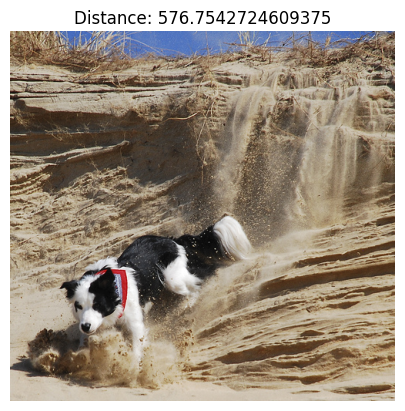

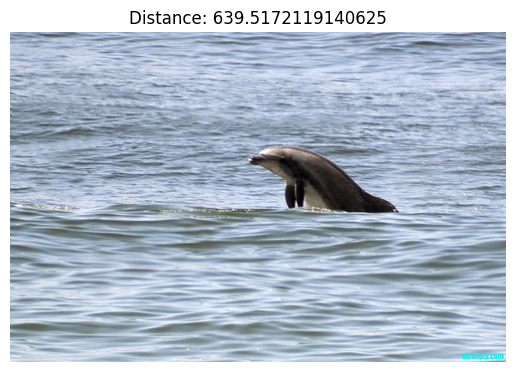

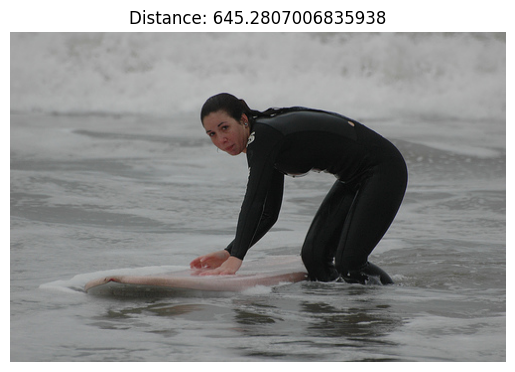

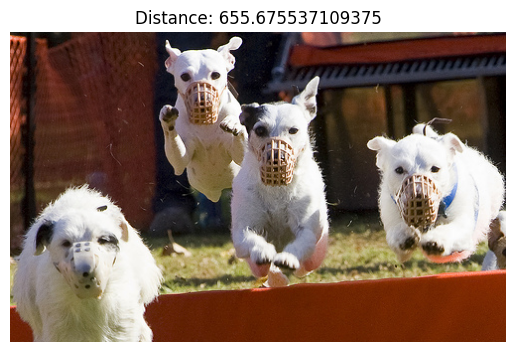

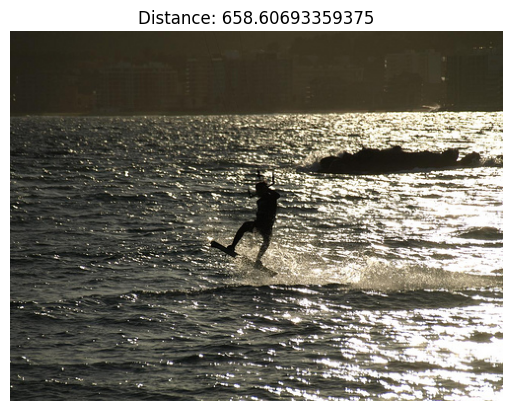

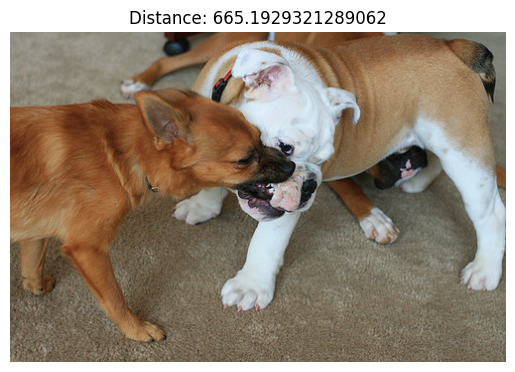

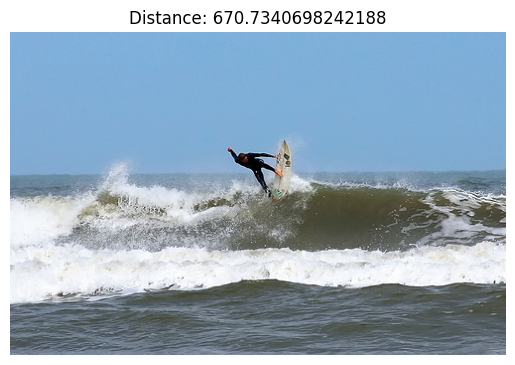

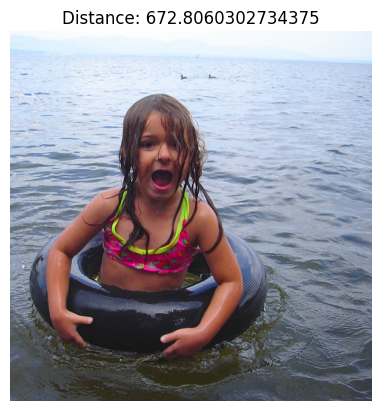

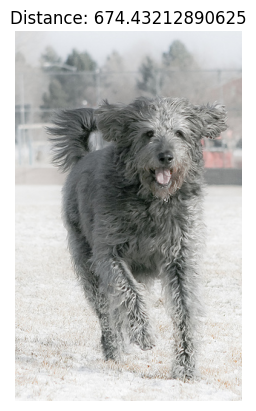

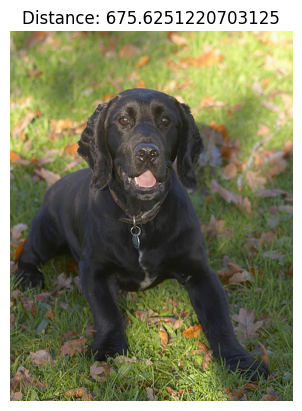

In [23]:
from PIL import Image
import matplotlib.pyplot as plt
# Example usage
input_image_path = '/content/drive/MyDrive/Images - Copy/1131155939_b4b457b05e.jpg'  # Replace with the path to your input image
search_results = search_with_image(input_image_path, k=10)

# Display search results
for img_path, distance in search_results:
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"Distance: {distance}")
    plt.axis('off')
    plt.show()